In [44]:
##########################################################################################
# Idea: K-arms are stocks.
# Action is picking a certain stock to invest everyday.
# Do one action each day. Number of step is equal to time span.
# pick one stock, buy at open, sell at close.
# reward: cumulative average daily return.
##########################################################################################
import math
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

#prepare for data,select price on open time and close time from stocks' information
df = pd.read_csv('Data.csv', index_col=0, header=[0, 1])
index = df.columns.get_level_values(1)[0:10]

openList = df.iloc[:, 40:50]
openList.columns = index

closeList = df.iloc[:, 10:20]
closeList.columns = index

In [45]:
#we will pick one stock each step,so choosing a stock is an action 
#    ActionCount: length of the stocks' list columns is the choice of action
#    stepCount: we will make action each timestamp,so length of the stocklist is the total number of steps
ActionCount = len(openList.columns)
stepCount = len(openList)

In [46]:
# #compute Qtrue[action]:cumulative average daily return on last step.
# Qtrue=np.zeros((ActionCount))
# for s in range(ActionCount):
#     ret = 0
#     for i in range(stepCount):
#         ret += (closeList.iloc[i,s]-openList.iloc[i,s])/openList.iloc[i,s]
#     Qtrue[s]= ret/stepCount

In [51]:
############################## ALGORITHM PART #############################################
class Bandit:
        def __init__(self,epsilon=0):
            self.epsilon = epsilon
            

        #initialize reward,Qta,NumAction and cumulative
        #    reward:a list of reward of each action prior to next step
        #    Qta:Q(t+1) a list of  weighted average reward of each action prior to next step
        #    NumAction:N(t+1) a list of the times each action has been done
        #    culmulative: a list of cumulative return of method by time t
        #Above variable will be update after action finished on time t
        def initial(self):
            self.Qestimate = np.zeros((ActionCount))
            self.NumAction = np.zeros((ActionCount))
            self.ucbF= np.zeros((ActionCount))
            self.aveReward=np.zeros((ActionCount))
            self.cumulative=0
          
        # buy a stock on open time and sell on close time,then have the rewardreturn
        def dailyReturn(self,t,stock):
            openprice = openList.iloc[t, stock]
            closeprice = closeList.iloc[t, stock]
            dailyReturn = (closeprice-openprice)/openprice
            return dailyReturn*100



        def eps_Greedy(self,step):
            # eps_Greedy use epsilon_Greedy method to balance exploration and exploitation
            p = np.random.rand()

            #get an action for this step
            if p <= self.epsilon:
                action = np.random.choice(ActionCount)
            else:
                action = np.random.choice(np.where(self.Qestimate == max(self.Qestimate))[0])


            # update
            reward = self.dailyReturn(step,action)
            self.cumulative+=reward
            self.aveReward[action] = self.cumulative/(step+1)
            self.NumAction[action] += 1
            self.Qestimate[action] += (self.aveReward[action] - self.Qestimate[action])/self.NumAction[action]
            #return reward of this step
            return self.aveReward[action]

        def decayEps_Greedy(self,step):
            #As we learn for a long time, we can make more educated decisions and explore less
            #To increase times of exploitation over time,make epsilon decay: epsilon=1/(1+t/actionCount)
            p = np.random.rand()

            #get an action for this step
            if p <= 1 / (1 + (step+1) / ActionCount):
                action = np.random.choice(ActionCount)
            else:
                action = np.random.choice(np.where(self.Qestimate == max(self.Qestimate))[0])


            # update
           
            reward = self.dailyReturn(step, action)
            self.cumulative+=reward
            self.aveReward[action] = self.cumulative/(step+1)

            #temp=rewardReturn(step, action)
            self.NumAction[action] += 1
            self.Qestimate[action] += (self.aveReward[action] - self.Qestimate[action])/self.NumAction[action]
            #return reward of this step
            return self.aveReward[action]



        def UCB(self,step):
            # NumAction(Nt(a)) is the times each action has been done
            # ucbF is the action selection function of Upper-Confidence-Bound Action Selection method,we want the Action At with max ucbF
            # initialize ucbF with 0,add and add small number 1e-5 to avoid the error when NumAction equal to 0
            # count ucbF for each action every step
            c=2
            for j in range(ActionCount):
                self.ucbF[j] = self.Qestimate[j] + c * (math.sqrt((math.log(step + 1)) / (self.NumAction[j] + 1e-5)))

            # choose the Action index whose ucbF is max
            action = np.random.choice(np.where(self.ucbF == max(self.ucbF))[0])

            #true reward = rewardReturn
            reward = self.dailyReturn(step, action)
            self.cumulative+=reward
            self.aveReward[action] = self.cumulative/(step+1)

            self.NumAction[action] += 1
            self.Qestimate[action] += (self.aveReward[action] - self.Qestimate[action])/self.NumAction[action]
            #return reward of this step
            return self.aveReward[action]

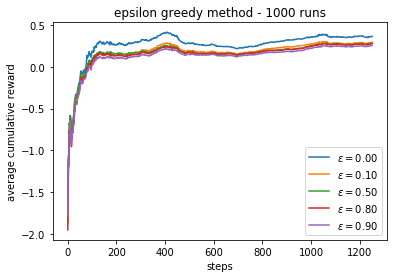

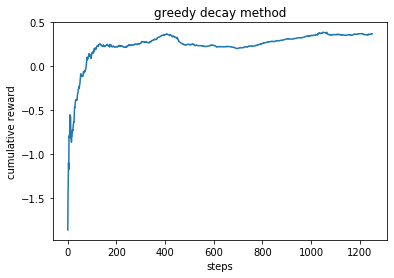

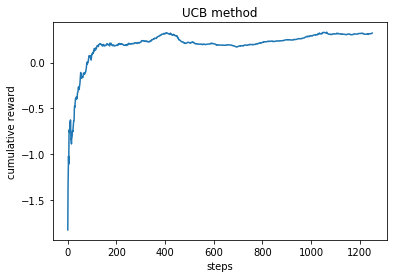

In [52]:
############################epsilon greedy result#################
#initialize the reward list and set up epsilon
#   traceReturn_eps:return of each step of epsilon greedy method
#   cumulativereturn_eps:cumulative return of each step of epsilon greedy method
runs=500
epsilon = [0,0.1,0.5,0.8,0.9]

cumulativereturn_eps=np.zeros((len(epsilon),runs,stepCount))
for eps in epsilon: 
    for r in range(runs):
        bandit_eps=Bandit(epsilon=eps)
        bandit_eps.initial()
        for i in range(stepCount):
            cumulativereturn_eps[epsilon.index(eps),r,i]=bandit_eps.eps_Greedy(step=i)
mean_cumu_rewards_eps = cumulativereturn_eps.mean(axis=1)

plt.figure()

for i in range(len(epsilon)):
        plt.plot(mean_cumu_rewards_eps[i,:], label='$\epsilon = %.02f$' % (epsilon[i]))
plt.xlabel('steps')
plt.ylabel('average cumulative reward')
plt.title("epsilon greedy method - 1000 runs")
plt.legend()
plt.savefig('p1.png')
#
############################greedy decay result###################
#initialize the reward list
#   traceReturn_decayEps:return of each step of greedy decay method
#   cumulativereturn_decayEps:cumulative return of each step of greedy decay method
#traceReturn_decayEps =np.zeros((runs,stepCount))
cumulativereturn_decayEps=np.zeros((runs,stepCount))

for r in range(runs):
    bandit_decayEps=Bandit()
    bandit_decayEps.initial()
    for i in range(stepCount):
        cumulativereturn_decayEps[r,i]=bandit_decayEps.decayEps_Greedy(i)


mean_cumu_rewards_decay = cumulativereturn_decayEps.mean(axis=0)

plt.figure()
plt.plot(mean_cumu_rewards_decay)
plt.xlabel('steps')
plt.ylabel('cumulative reward')
plt.title("greedy decay method")
plt.savefig('p2.png')
###########################UCB result##################
#initialize the reward list
#   traceReturn_UCB:return of each step of greedy decay method
#   cumulativereturn_UCB:cumulative return of each step of greedy decay method
# initialize ucbF with 0
#traceReturn_UCB= np.zeros((runs,stepCount))
cumulativereturn_UCB= np.zeros((runs,stepCount))

for r in range(runs):
    bandit_UCB=Bandit()
    bandit_UCB.initial()
    for i in range(stepCount):
        cumulativereturn_UCB[r,i]=bandit_UCB.UCB(i)


#mean_rewards_ucb = traceReturn_UCB.mean(axis=0)
mean_cumu_rewards_ucb = cumulativereturn_UCB.mean(axis=0)


plt.figure()
plt.plot(mean_cumu_rewards_ucb)
plt.xlabel('steps')
plt.ylabel('cumulative reward')
plt.title("UCB method")
plt.savefig('p3.png')